In [13]:
from feast import FeatureStore
from sklearn.model_selection import train_test_split
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from joblib import load

In [14]:
# Getting our FeatureStore
store = FeatureStore(repo_path=".")

In [15]:
# Retrieving the saved dataset and converting it to a DataFrame
training_df = store.get_saved_dataset(name="churn_dataset").to_df()
training_df

C:\Users\damia\AppData\Roaming\Python\Python311\site-packages\feast\feature_store.py:1178: RuntimeWarning: Retrieving datasets is an experimental feature. This API is unstable and it could and most probably will be changed in the future. We do not guarantee that future changes will maintain backward compatibility.
  warnings.warn(


,Gender,Geography_Spain,Age,CreditScore,Tenure,Balance,event_timestamp,Geography_Germany,EstimatedSalary,Geography_France,IsActiveMember,USER_ID,NumOfProducts,Exited,HasCrCard
0,0,False,29,792,4,107601.79,2023-01-01 00:00:00+00:00,True,18922.18,False,0,3618,1,1,1
1,0,False,39,686,3,111695.62,2023-01-01 00:00:00+00:00,False,136643.84,True,0,3152,1,0,0
2,0,False,54,572,9,97382.53,2023-01-01 00:00:00+00:00,True,195771.95,False,1,4195,1,0,1
3,1,False,37,643,6,0.00,2023-01-01 00:00:00+00:00,False,142454.77,True,0,8080,2,0,0
4,1,True,48,587,1,0.00,2023-01-01 00:00:00+00:00,False,8908.00,False,1,2599,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,False,24,764,7,0.00,2023-12-31 00:00:00+00:00,False,186105.99,True,0,1195,2,0,1
9996,1,False,61,850,3,141784.02,2023-12-31 00:00:00+00:00,True,92053.75,False,1,4492,1,0,1
9997,1,False,36,744,10,0.00,2023-12-31 00:00:00+00:00,False,182867.84,True,1,9303,2,0,1
9998,1,False,31,850,4,146587.30,2023-12-31 00:00:00+00:00,True,89874.82,False,1,6664,1,0,1


In [16]:
# Separating the features and labels
labels = training_df['Exited']
features = training_df.drop(
    labels=['Exited', 'event_timestamp', "USER_ID"],
    axis=1)

In [17]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    stratify=labels)

In [18]:
columns_order = load(r'data/columns_order.joblib')
columns_order

Index(['HasCrCard', 'Geography_Germany', 'Gender', 'Geography_France',
       'CreditScore', 'Geography_Spain', 'NumOfProducts', 'IsActiveMember',
       'Tenure', 'Age', 'Balance', 'EstimatedSalary'],
      dtype='object')

In [19]:
# Riorganizza le colonne di X_test in base all'ordine delle colonne utilizzate durante l'addestramento
X_test = X_test[columns_order]
X_train = X_train[columns_order]

### Train - Random Forest

In [20]:
# Inizializza il modello
forest = RandomForestClassifier(n_estimators=100, random_state=42)
# Addestra il modello
forest.fit(X=X_train, y=y_train)

RandomForestClassifier(random_state=42)

In [21]:
dump(forest, r'data/random_forest_model.joblib')

['data\\random_forest_model.joblib']

In [22]:
X_train.columns

Index(['HasCrCard', 'Geography_Germany', 'Gender', 'Geography_France',
       'CreditScore', 'Geography_Spain', 'NumOfProducts', 'IsActiveMember',
       'Tenure', 'Age', 'Balance', 'EstimatedSalary'],
      dtype='object')

In [23]:
# Load random forest model
logistic = load(r'data/logistic_regression.joblib')

In [24]:
y_pred_prob_1 = forest.predict_proba(X_test)[:, 1]
y_pred_prob_2 = logistic.predict_proba(X_test)[:, -1]

In [25]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_prob_1)
auc_1 = roc_auc_score(y_test, y_pred_prob_1)

In [26]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_prob_2)
auc_2 = roc_auc_score(y_test, y_pred_prob_2)

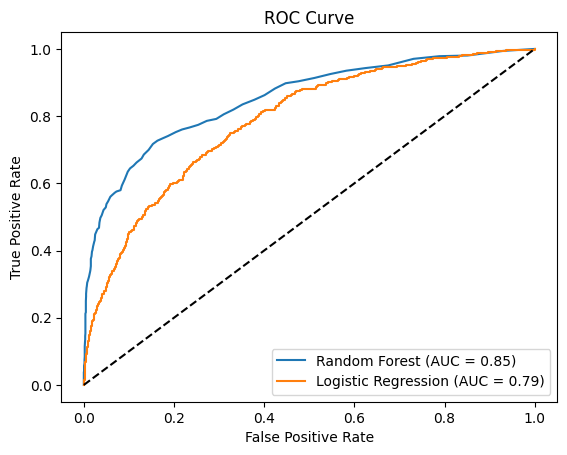

In [27]:
plt.plot(fpr_1, tpr_1, label=f'Random Forest (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()